In [2]:
from models import *
from epmt_job import setup_orm_db
import fnmatch

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['figure.figsize'] = [15, 8]

import numpy as np
import pandas as pd

import settings
settings.db_params["host"] = "db"
setup_orm_db()


In [3]:
def barplot(labels=[], y_val=[], mn="None", yscale="log", title_suffix="by executable"):
    index = np.arange(len(labels))
    plt.yscale(yscale)
    plt.bar(index, y_val)
# performance, align='center', alpha=0.5)
    plt.xticks(index, labels, fontsize=10, rotation=45)
# y_pos, objects)
    plt.ylabel(mn)
    plt.title(mn+' '+title_suffix)
    plt.show()

def barplot_stack(labels=[], y_val=[], y2_val=[], mn=[], yscale="log", ylim=(), title_suffix="by executable"):
    index = np.arange(len(labels))
    plt.yscale(yscale)
    p1 = plt.bar(index, y_val, color='r')
    p2 = plt.bar(index, y2_val, bottom=y_val, color='g')
# performance, align='center', alpha=0.5)
    plt.xticks(index, labels, fontsize=10, rotation=45)
# y_pos, objects)
    plt.ylabel(mn[0]+"+"+mn[1])
    plt.legend((p1[0], p2[0]), (mn[0], mn[1]))
    plt.title(mn[0]+"+"+mn[1]+' '+title_suffix)
    plt.ylim(ylim)
    plt.show()

In [4]:
def get_job_list():
    q = select(j for j in Job)
    return q[:]
    
# Return list of objects for jobid

def get_processes_job(jobid):
    # lookup job
    try:
        j = Job[jobid]
    except Exception as e:
        print("not found",e)
        return None
    print("Found job",jobid,"with",len(j.processes),"processes and",len(j.processes.threads),"threads")
    return j.processes
    
# Reduce all processes by executable name and return sums of metric

    # we could do this with a query, maybe
    # processes=select((p.exename, sum(p.duration), count(p)) for p in Process if p.job == j).order_by(-2)
    #    for p in processes:
    #        threads += p.threads

def get_job_processes_reduce_attr(jobid, attr_name, cutoff=0.0, exelen=10):
    processes = get_processes_job(jobid)
    if not processes:
        return
    proc_dict={}
    total = 0.0
    for p in processes:
        exename = p.exename[:exelen]
        if exename not in proc_dict:
            proc_dict[exename] = {}
            proc_dict[exename]["count"] = 1
            proc_dict[exename]["threads"] = len(p.threads)
            proc_dict[exename][attr_name] = getattr(p, attr_name)
        else:
            proc_dict[exename]["count"] += 1
            proc_dict[exename]["threads"] += len(p.threads)
            proc_dict[exename][attr_name] += getattr(p, attr_name)
        total += getattr(p, attr_name)
    
    if cutoff > 0.0:
        for key in list(proc_dict):
            if proc_dict[key][attr_name] < cutoff:
                del proc_dict[key]
       
    return (total, proc_dict)

# Reduce all processes by executable name and return sums of metric

def get_job_processes_full_attr(processes, attr_name, cutoff=0.0, exelen=10):
    proc_dict={}
    total = 0.0
    for p in processes:
        exename = p.exename[:exelen] 
        if exename not in proc_dict:
            proc_dict[exename] = {}
            proc_dict[exename][attr_name] = [getattr(p, attr_name)]
            proc_dict[exename]["start"] = [getattr(p, "start")]                     
        else:
            proc_dict[exename][attr_name].append(getattr(p, attr_name))
            proc_dict[exename]["start"].append(getattr(p, "start"))
        total += getattr(p, attr_name)
    
    if cutoff > 0.0:
        for key in proc_dict.keys():
            if proc_dict[key][attr_name] < cutoff:
                del proc_dict[key]
       
    return (total, proc_dict)

In [5]:
js = get_job_list()
for j in js:
    print(j.jobid,"from",j.start,"to",j.end,"by",j.user.name,"took",j.duration/1e6,"s.")
    if j.ppr:
        print("\t","Post-processing run, job.name:",j.jobname)
        print("\t","Post-processing run, ppr.component:",j.ppr.component)
        print("\t","Post-processing run, ppr.name:",j.ppr.name)
        print("\t","Post-processing run, ppr.jobname:",j.ppr.jobname)
        print("\t","Post-processing run, ppr.oname:",j.ppr.oname)


20294924.moab01.princeton.rdhpcs.noaa.gov from 2019-02-15 17:48:39.246671 to 2019-02-15 19:03:26.082247 by Jeffrey.Durachta took 4486.835576 s.
	 Post-processing run, job.name: CM4_piControl_C_atmos_00050101
	 Post-processing run, ppr.component: atmos
	 Post-processing run, ppr.name: CM4_piControl_C
	 Post-processing run, ppr.jobname: CM4_piControl_C_atmos_00050101
	 Post-processing run, ppr.oname: 00050101
20294925.moab01.princeton.rdhpcs.noaa.gov from 2019-02-15 17:48:39.250163 to 2019-02-15 18:56:55.801626 by Jeffrey.Durachta took 4096.551463 s.
	 Post-processing run, job.name: CM4_piControl_C_atmos_level_00050101
	 Post-processing run, ppr.component: atmos_level
	 Post-processing run, ppr.name: CM4_piControl_C
	 Post-processing run, ppr.jobname: CM4_piControl_C_atmos_level_00050101
	 Post-processing run, ppr.oname: 00050101
20294926.moab01.princeton.rdhpcs.noaa.gov from 2019-02-15 17:48:39.250799 to 2019-02-15 19:12:04.238002 by Jeffrey.Durachta took 5004.987203 s.
	 Post-processin

Found job 20294924.moab01.princeton.rdhpcs.noaa.gov with 37464 processes and 42314 threads


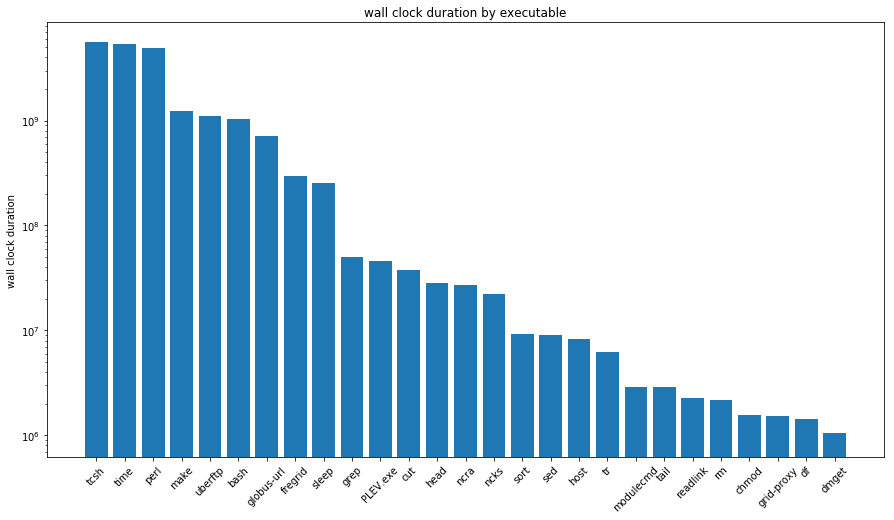

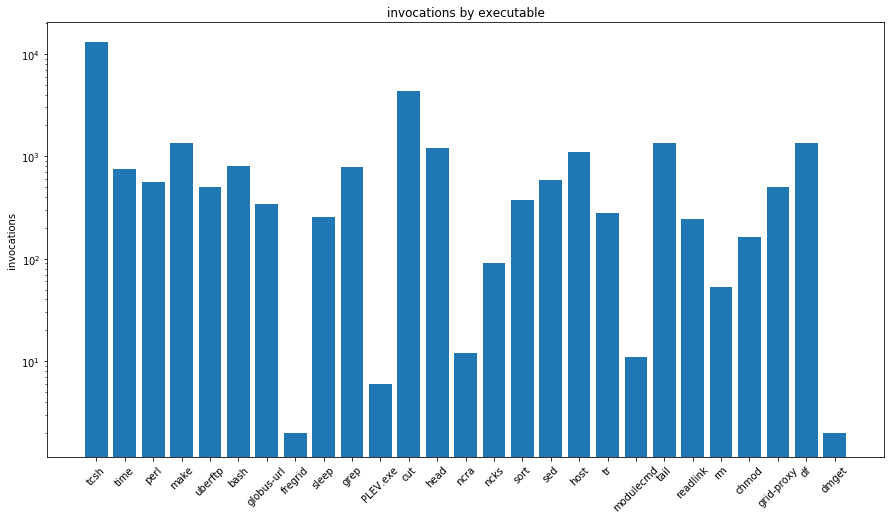

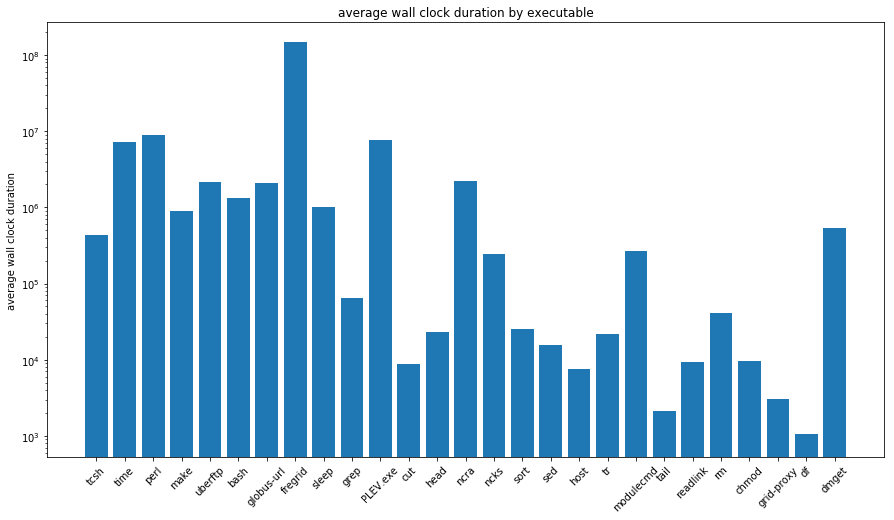

In [6]:
j = js[0].jobid
total, proc_dict = get_job_processes_reduce_attr(jobid=j, attr_name='duration', cutoff=1000000.0)
labels = []
y_val = []
y_val2 = []
y_val3 = []
labels = sorted(proc_dict.keys())
labels = sorted(proc_dict, key=lambda k: (proc_dict[k]["duration"]), reverse=True)
for k in labels:
    value = proc_dict[k]
    y_val3.append(value["duration"]/value["count"])
    y_val.append(value["duration"])
    y_val2.append(value["count"])
    
barplot(labels=labels,y_val=y_val,mn="wall clock duration")
barplot(labels=labels,y_val=y_val2,mn="invocations")
barplot(labels=labels,y_val=y_val3,mn="average wall clock duration")



In [7]:
# Return list of objects for jobid

def get_processes_job_filter(jobid, pat=None):
    query = select ((p.exename, p.start, p.duration) for p in Process 
                    if p.job in select(j for j in Job if j.jobid == jobid)).order_by(2)
    if pat:
        query = query.filter(lambda p, q, r: p.startswith(pat))
    return query[:]

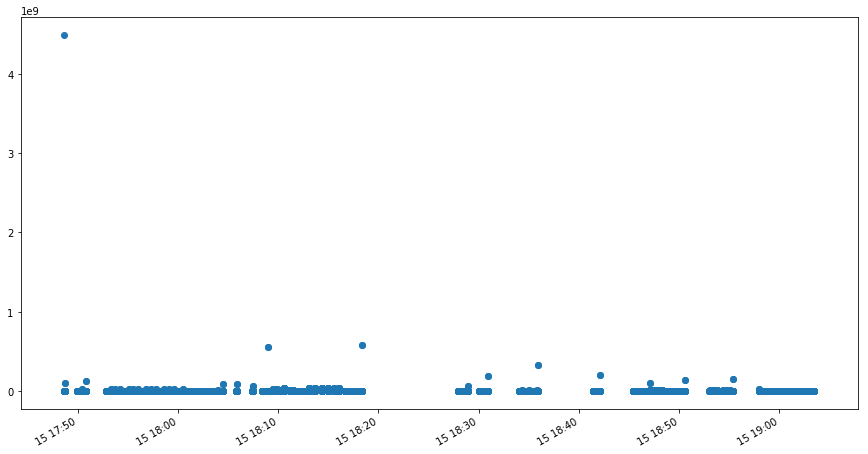

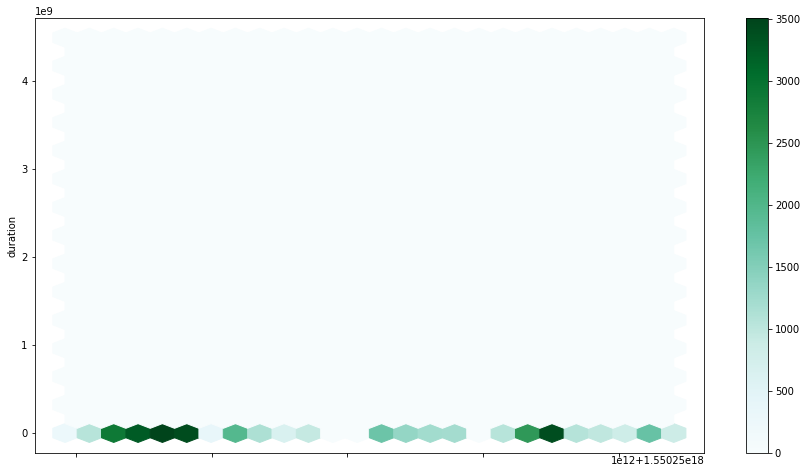

In [8]:
a = get_processes_job_filter(jobid=j)    
#print(a)
e,t,d = zip(*a)
plt.plot([],[])
plt.scatter(t,d)
plt.gcf().autofmt_xdate()
plt.show()

df = pd.DataFrame( { 'time': t, 'duration': d })
df['time'] = pd.to_numeric(df['time'])
df.plot.hexbin(x='time', y='duration', gridsize=25)


In [9]:
# Returns rows of dataframe where metric value is bigger than quantile
def get_outliers_by_quantile(pdf, metric, quantile_to_return=.999):
    cutoff = pdf[metric].quantile(q=quantile_to_return)
    return pdf[pdf[metric] > cutoff]

def print_outliers(d, metric):
    if len(d.index):
        print("\t",len(d.index),"outliers in metric",metric,"mean",d[metric].describe()["mean"]) 
    for index, row in d.iterrows():
        thr = row['thread']
        proc = thr.process
        print("\t",thr,proc,proc.exename+"("+str(proc.pid)+") at",proc.start,metric,row[metric])
        
def remove_outliers(dfi, dfol):
    dfi = dfi[~dfi.thread.isin(dfol.thread)]
    return dfi

In [10]:
tofind = [ "delayacct_blkio_time","usertime","invol_ctxsw","time_oncpu","time_waiting","systemtime" ]

# This function gets all metrics and Thread(primary key) in all input JIDS that match EXE
# Input: list of JIDS and exename
# Output: DataFrame with 'thread' and N columns of metrics

def get_df_all_process(jids,exe):
    q = Process.select(lambda p: p.job in jids and p.exename==exe).without_distinct()
#    print "exe",exe,"ran",len(q),"times"
    q = select(p.threads.metrics for p in q).without_distinct()
# order by is important as it always produces the same order of threads
    q = select((m.value,m.metricname.name,m.thread) for m in q).without_distinct().order_by(3)
# make lists
    meas = {}
    for m in q[:]:
        if m[1] not in meas:
            meas[m[1]] = [ (m[0], m[2]) ]
        else:
            meas[m[1]].append( (m[0], m[2]) )
# make df
    df = pd.DataFrame()
    for k in tofind:
        if k in meas:
            v,t = zip(*meas[k])
            df[k] = v
            if 'thread' not in df.columns:
                df['thread'] = t
    return df

# This function develops filtering/outlier criteria from a set of jobs, by executable
# Input: List of JIDS
# Output: Dictionary by exe of statistical data for each metric (mean/stddev/etc)

def get_filter_criteria(by_jids):
# First compute averages of filter/reference jobs
    q1 = Process.select(lambda p: p.job in by_jids).without_distinct()
    q1 = select(p.exename for p in q1).order_by(1) #.without_distinct()
    criteria = {}
    for exe in q1[:]:
        df = get_df_all_process(by_jids,exe)
        print(exe,len(df))
        outlier_dfs=[]
        outlier_procs=[]
        for metric in tofind:
            #       print len(df[metric])
            b = get_outliers_by_quantile(df[['thread',metric]].copy(),metric)
            #       print len(b)
            #print_outliers(b,metric)
            outlier_dfs.append(b)
            for index, row in b.iterrows():
                outlier_procs.append(row['thread'].process)
        #print "Processes with more than one outlier"
        #procs,metrics = zip(*outlier_procs)
        procs = outlier_procs
        dfvc = pd.DataFrame({'thread': procs})
        vc = dfvc['thread'].value_counts()
        vc = vc[ vc != 1]
#        for index, value in vc.iteritems():
#            print index,index.exename,"on",index.host.name,"at",index.start,"for",index.duration
#        if len(vc):
#            vc.plot.bar(subplots=True,title=index.exename+" processes with > 1 outlier",color=['darkblue'])
#            plt.show()
# FIX:      We should record which outlier(s) for each process!
#            pass
        newdf = df
        for d in outlier_dfs:
            newdf = remove_outliers(newdf,d)
#        print df.describe()
        criteria[exe] = newdf.describe()
    return criteria
#
# If we get here, we now have, by executable, a set of criteria to filter the input jobs
#
# Criteria is a dict [exe][metric]["std" or "dev"]
# Should be an object with a method

def filter_jobs(jids,exe_criteria,zscore_threshold=3.0):
    q1 = Process.select(lambda p: p.job in jids).without_distinct()
    q1 = select(p.exename for p in q1).order_by(1) #.without_distinct()
    criteria = {}
    for exe in q1[:]:
        df = get_df_all_process(jids,exe)
        print(exe,len(df))
        # create dataframe for zscores for this exe, all metrics
        zscores = pd.DataFrame(columns=tofind)
#        zscores['thread'] = df['thread']
        # for each column/metric
        for column in df:
            if column == 'thread':
                continue
            metric = column
            if metric not in tofind:
                continue
            if exe not in exe_criteria:
                continue
            mean = exe_criteria[exe][metric]["mean"]
            std = exe_criteria[exe][metric]["std"]
            if mean == 0 and (std == 0 or std == pd.np.nan):
#                print metric,exe,"mean is 0 or std is 0/Nan, skipping"
                zscores[metric] = pd.Series(False, index=df.index)
                continue
#            print "checking",len(df),exe,"metric",metric,"against mean",mean,"stddev",std
# Z-score (X-mu)/sigma
            zscores[column] = (abs(df[column] - mean)/std > zscore_threshold)
# Does any row have a True?    
        zs = zscores.any(axis='columns')
# Which ones?
        indices = zs[zs == False].index
# Drop non-outliers
        df.drop(indices, inplace=True)
        zscores.drop(indices,inplace=True)
        print("*** ",exe,"has",len(df),"outliers ***")
        for index, row in df.iterrows():
            print(row)
            print(zscores.loc[index, :])

    return False, False

#criteria = get_filter_criteria([js[0]])        
#outliers, outlier_metrics = filter_jobs([js[0]],criteria)
#print(outlier_metrics)



In [13]:
ref_jobs=[]
js = get_job_list()
for j in js:
    if j.ppr:
        print(j.jobid,"("+j.ppr.component+")","from",j.start,"by",j.user.name,"took",j.duration/1e6,"s.")
        ref_jobs.append(j)
#print ref_jobs
criteria = get_filter_criteria(ref_jobs)

print("means and stddev of criterion for outlier detection")
for e in sorted(criteria):
    print(e)
    for m in criteria[e]:
        lms = criteria[e].loc['mean',m]
        lmsd = criteria[e].loc['std',m]
        print("\t",m,lms,lmsd,lmsd/lms)
#outliers, outlier_metrics = filter_jobs([js[0]],criteria)
#print outlier_metrics


20294924.moab01.princeton.rdhpcs.noaa.gov (atmos) from 2019-02-15 17:48:39.246671 by Jeffrey.Durachta took 4486.835576 s.
20294925.moab01.princeton.rdhpcs.noaa.gov (atmos_level) from 2019-02-15 17:48:39.250163 by Jeffrey.Durachta took 4096.551463 s.
20294926.moab01.princeton.rdhpcs.noaa.gov (atmos_level_cmip) from 2019-02-15 17:48:39.250799 by Jeffrey.Durachta took 5004.987203 s.
20294927.moab01.princeton.rdhpcs.noaa.gov (atmos_month_aer) from 2019-02-15 17:48:39.255221 by Jeffrey.Durachta took 3877.076117 s.
20294929.moab01.princeton.rdhpcs.noaa.gov (ocean_annual_1x1deg) from 2019-02-15 17:48:39.250164 by Jeffrey.Durachta took 3140.776301 s.
20294930.moab01.princeton.rdhpcs.noaa.gov (ocean_bling_1x1deg) from 2019-02-15 17:48:39.247442 by Jeffrey.Durachta took 1711.900928 s.
20294931.moab01.princeton.rdhpcs.noaa.gov (tracer_level) from 2019-02-15 17:48:39.249980 by Jeffrey.Durachta took 4847.671178 s.
arch 1391
basename 151
bash 4029
cat 363
chmod 796
cp 113
cut 20648
date 680
df 6582


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()


 0.778494204828
	 invol_ctxsw 1.03477572399 1.36142329797 1.31566992384
	 time_oncpu 9329736.20766 7406689.19521 0.79387980864
	 time_waiting 33753.5666738 181379.119698 5.37362825834
	 systemtime 2697.72511343 3049.88037623 1.13053785986
test
	 delayacct_blkio_time 0.0 0.0 nan
	 usertime 5533.82009346 1472.67712791 0.2661230584
	 invol_ctxsw 1.72897196262 0.898294960065 0.519554382308
	 time_oncpu 9543444.42991 2206008.68117 0.231154348661
	 time_waiting 21835.6098131 37416.3160988 1.71354573649
	 systemtime 3473.28271028 1726.31917097 0.497028118634
time
	 delayacct_blkio_time 8.72752661896 295.320706647 33.8378465676
	 usertime 5615.95304591 1498.93619915 0.266906825412
	 invol_ctxsw 1.63710944318 0.869500929664 0.531119610411
	 time_oncpu 9845223.30634 2197995.66939 0.223255034549
	 time_waiting 26991.9350672 95583.044926 3.54117052698
	 systemtime 3729.26444406 1723.41539509 0.462132793461
touch
	 delayacct_blkio_time 0.0 0.0 nan
	 usertime 6596.72966208 1759.6440656 0.26674491084

In [ ]:
# Lets examine tcsh

q = Process.select(lambda p: p.job==js[0] and p.exename=="globus-url-copy").without_distinct()
q = select(p.threads.metrics for p in q).without_distinct()
q = select((m.value,m.metricname.name,m.thread) for m in q).without_distinct().order_by(3)
# order by is important as it always produces the same order of threads
meas = {}
for m in q[:]:
    if m[1] not in meas:
        meas[m[1]] = [ (m[0], m[2]) ]
    else:
        meas[m[1]].append( (m[0], m[2]) )

# Very important to be sorted by thread object here!

df = pd.DataFrame()
for k in tofind:
    if k in meas:
        v,t = zip(*meas[k])
        df[k] = v
        if 'thread' not in df.columns:
            df['thread'] = t

# TEST
#t = Thread[41211]
#print t,t.process
#print t.metrics.value
# Thread[23153] Process[20602] tcsh at 2019-02-15 18:46:10.422353 delayacct_blkio_time 10000.0
# Thread[38021] Process[33690] tcsh at 2019-02-15 18:01:31.958077 delayacct_blkio_time 2520000.0
        

outlier_dfs=[]
outlier_procs=[]
for metric in tofind:
    print
#    a = pd.DataFrame()
    b = pd.DataFrame()
    b = get_outliers(df[['thread',metric]].copy(),metric)
    print_outliers(b,metric)
    outlier_dfs.append(b)
    for index, row in b.iterrows():
            outlier_procs.append(row['thread'].process) 

#print outliers
print("Processes with more than one outlier")
dfvc = pd.DataFrame({'thread': outlier_procs})
vc = dfvc['thread'].value_counts()
vc = vc[ vc != 1]
#badboys = pd.DataFrame(columns=["key","exe","host","time","duration_us"])
for index, value in vc.iteritems():
        print(index,index.exename,"on",index.host.name,"at",index.start,"for",index.duration)
ax = vc.plot.bar(title="Processes with more than one outlier",color=['darkblue'])


newdf = df
for d in outlier_dfs:
    newdf = remove_outliers(newdf,d)

print(df.describe())
print(newdf.describe())

In [ ]:


#df = pd.DataFrame({'Duration': q[:]})
#print df.describe()
#array = [durs]
#plt.boxplot(array,showmeans=True,whis=99)
#plt.show()




In [ ]:
#    for key, value in proc_dict.iteritems():
#        if value["threads"] > value["count"]:
#            print key, value["duration"], total, value["duration"]*100.0/total 
#        names["foo"] += 1
#        attr[p.exename] += p.duration



#jobs=select(j for j in Job if j.jobid == jobid)
#for j in jobs:
#    print "Job found:",j.jobname, j.jobid

# print "TOTAL:",len(processes)
#print processes
#for p in processes:
#    print p
#processes=select((p.exename, p.duration) for p in Process if p.job == j and p.exename == "tcsh").order_by(-2)
#print "TCSH:", len(processes)
#print "SUM:",sum(p.duration for p in Process if p.job == j and p.exename == "tcsh")
# for p in processes:
#    print p[1]
# Slice up tuples into X and Y
# print labels



In [ ]:
#    
    Process.select(lambda p: p.job == jobid)
    
    j.processes w# lookup job


    doit = False
        for pat in exepatlist:
            if fnmatch.fnmatch(p.exename, pat):
                doit = True
                break
        if not doit:
            continue
total, proc_dict = get_job_processes_full_attr(jobid='19917749.moab01.princeton.rdhpcs.noaa.gov', attr_name='duration', exepatlist=["gl*"])

#print proc_dict
x_val = []
y_val = []
for key, value in proc_dict.iteritems():
    plt.plot([ i for i in range(len(value["start"]))],value["start"])
    plt.show()

print value["start"]

#threads=select(p.threads for p in Process if p.job == j)
#print "TOTAL:",len(threads)
#print j
metricnames=select(m.name for m in MetricName)[:]
#print metricnames, len(metricnames)

values=select((m.thread.process.exename, m.metricname.name, sum(m.value)) for m in Metric if m.thread.process.job == j and m.thread.process.exename == 'which').order_by(2)
#metricname == MetricName["usertime"])[:10]
#print len(values), values[:]
# foundmetricnames=[t[1] for t in values][:len(metricnames)]
# print foundmetricnames,len(foundmetricnames)
numexes = len(values)/len(metricnames)

# Iterate over metrics, using number of executables at a time
for offset in range(0,len(values),numexes):
    mn = (values[:])[offset][1]
    procnames = [p[0] for p in values[offset:offset+numexes]]
    y_val = [p[2] for p in values[offset:offset+numexes]]
    if all(i == 0.0 for i in y_val):
        print offset,mn,"had no non-zero values"
    else:
        print offset, mn
        print procnames
        print y_val
        #barplot(labels=procnames,y_val=y_val,mn=mn)

values=select((m.thread.process.pid, m.value) for m in Metric if m.metricname.name == "rssmax" and m.thread.process.exename == 'which').order_by(2)





In [ ]:
values=select((m.thread.process.exename, sum(m.thread.process.duration), m.metricname.name, sum(m.value)) for m in Metric if m.metricname.name == "systemtime" or m.metricname.name == "usertime" ).order_by(3)
print len(values)
i=len(values)/2
print i,values[0:1]
print values[64:65]
procnames = [p[0] for p in values[0:i]]
y_val1 = [p[3] for p in values[0:i]]
y_val2 = [p[3] for p in values[i:len(values)]]
barplot_stack(labels=procnames,y_val=y_val1, y2_val=y_val2,mn=["systemtime", "usertime"],yscale="linear",ylim=(0,100000000))

#

In [ ]:
print len(values[:])

In [ ]:
for p in processes:
    print count(p.threads), p.exename, p.duration
    #s um(p.threads.duration), p.threads.metrics
    threads=select (t for t in Thread if t.process == p)
    for t in threads:
            print "\t", t.tid, t.duration

In [ ]:
select((p.exename, count(p)) for p in Process if p.job == j).without_distinct()[:]
                                                                                 